In [1]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats
from scipy.stats import ttest_ind

In [2]:
#Set all settings for the resulting figures

import seaborn as sns
sns.set()

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.tight_layout()

In [3]:
data_folder = "../../Data"
structured_data_folder = data_folder + "/structured_data"
text_path = data_folder + "/text"
data_path = structured_data_folder + "/test.csv"
dist_folder = structured_data_folder + "/Distances"
figure_folder = "../Figures/Results/Embeddings"
model_folder = "../Models/Embeddings"
matches = pd.read_csv(structured_data_folder + "/Matches/Bas.csv", index_col=0)
figure_folder = "../Figures/EDA/"

In [4]:
transactions = load_transactions("../../Data/structured_data\VOC Cochin Slave Transactions 1706-1801 - IISH - Database - 2018 - v1.csv")
permissions = load_permissions("../../Data/structured_data\VOC Cochin Slave Transport Permissions 1770-1795 - IISH - Database - 2018 - v1.csv")

E:\UvA\Scriptie\Thesis_code\Annotation\Annotation_helper.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  col = col.str.replace('[^a-zA-Z ]', '')


In [5]:
transactions["Verkopernaam"] = transactions["VerkoperVoornaam"].fillna("") + " " + transactions["VerkoperTussen"].fillna("") + " " + transactions["VerkoperAchternaam"].fillna("")
transactions["Kopernaam"] = transactions["KoperVoornaam"].fillna("") + " " + transactions["KoperTussen"].fillna("") + " " + transactions["KoperAchternaam"].fillna("")
permissions["Bezitternaam"] = permissions["BezitterVoornaam"].fillna("") + " " + permissions["BezitterTussen"].fillna("") + " " + permissions["BezitterAchternaam"].fillna("")

In [6]:
print("Number of unique sellers: ", len(transactions["Verkopernaam"].unique()))
print("Number of unique buyers: ", len(transactions["Kopernaam"].unique()))
print("Number of unique owners: ", len(permissions["Bezitternaam"].unique()))

Number of unique sellers:  4648
Number of unique buyers:  3297
Number of unique owners:  1224


# Reviewing the status of owners

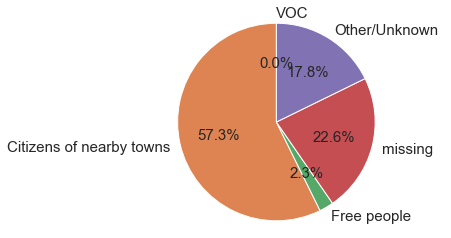

In [7]:
n_total = transactions.shape[0]
n_voc_sellers = (transactions["VerkoperStatus"] == "VOC").sum()
n_inw_sellers = transactions["VerkoperStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = transactions["VerkoperStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = transactions["KoperStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'seller_status.png', bbox_inches='tight')

[0, 367, 935, 1626, 4260]


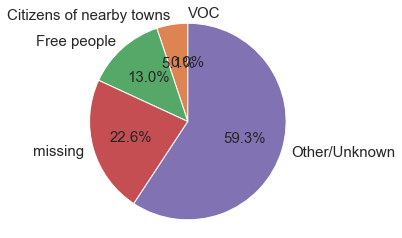

In [8]:
n_total = transactions.shape[0]
n_voc_sellers = (transactions["KoperStatus"] == "VOC").sum()
n_inw_sellers = transactions["KoperStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = transactions["KoperStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = transactions["KoperStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))
print(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'buyer_status.png', bbox_inches='tight')

[0, 10, 167, 2991, 670]


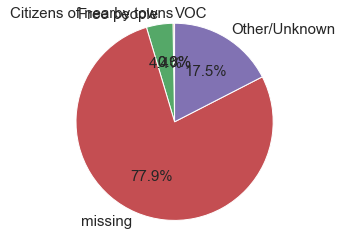

In [9]:
n_total = permissions.shape[0]
n_voc_sellers = (permissions["BezitterStatus"] == "VOC").sum()
n_inw_sellers = permissions["BezitterStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = permissions["BezitterStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = permissions["BezitterStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))
print(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'owner_status.png', bbox_inches='tight')

# Plot missing values of different features

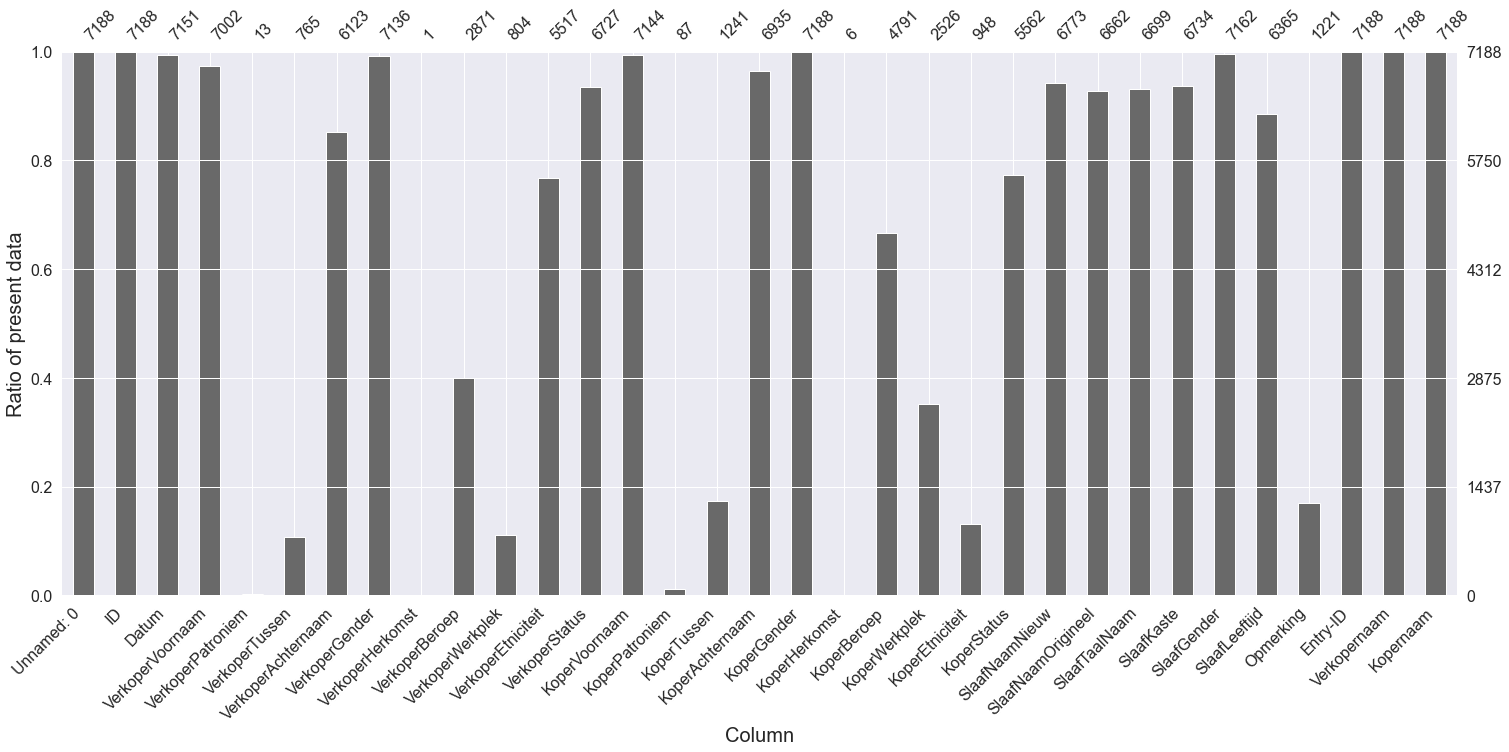

In [10]:
fontsize = 20
ax = msno.bar(transactions)
ax.set_xlabel('Column', fontsize=fontsize)
ax.set_ylabel('Ratio of present data', fontsize=fontsize)

plt.savefig(figure_folder + 'missing_transaction.png', bbox_inches='tight')

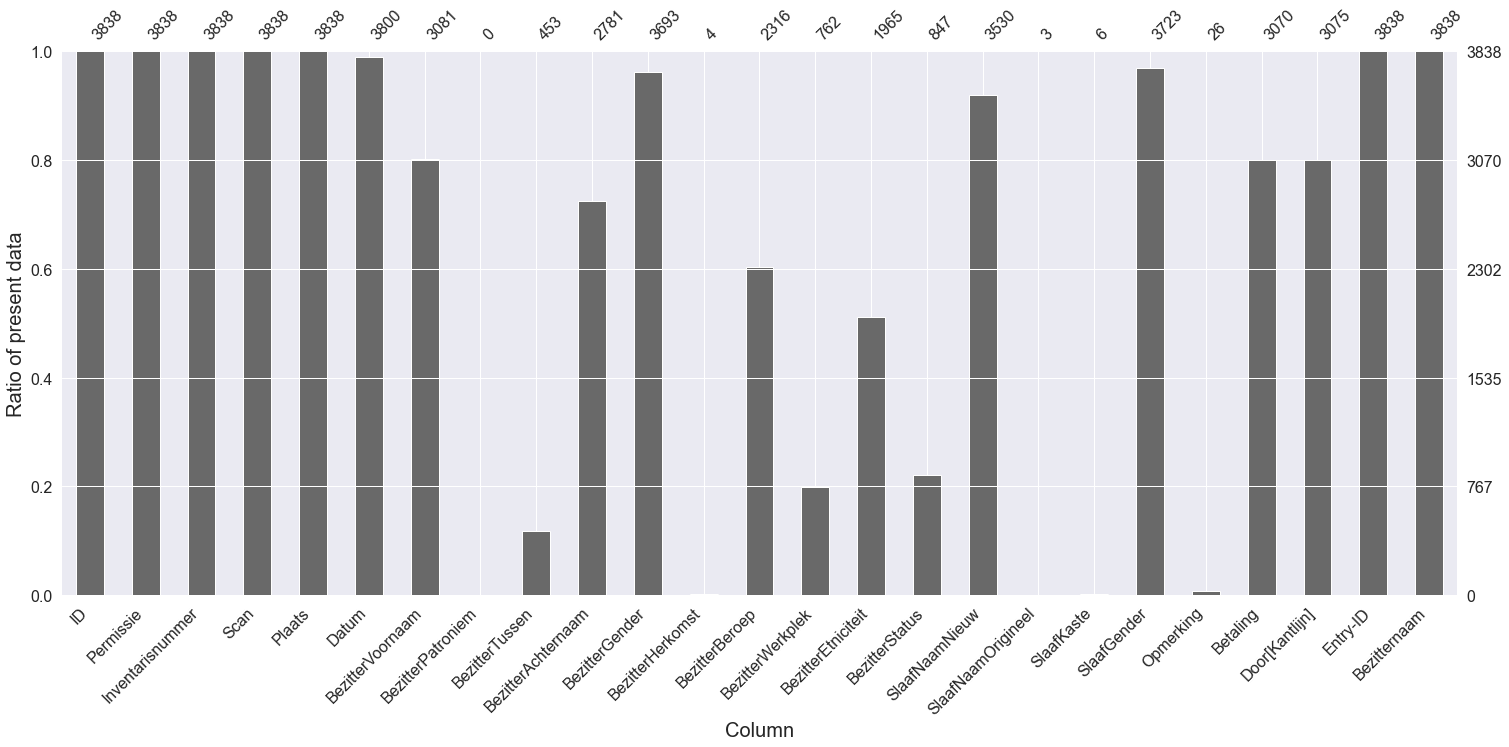

In [11]:
fontsize = 20
ax = msno.bar(permissions)
ax.set_xlabel('Column', fontsize=fontsize)
ax.set_ylabel('Ratio of present data', fontsize=fontsize)

plt.savefig(figure_folder + 'missing_permission.png', bbox_inches='tight')

# Distances EDA

In [12]:
distances = pd.read_csv(dist_folder + "/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"{dist_folder}/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])
distances.reset_index(inplace=True)

In [13]:
distances["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index
        distances.loc[indx, "Match"] = 1

In [14]:
only_matches = distances[distances["Match"] == 1]
no_matches = distances[distances["Match"] == 0]

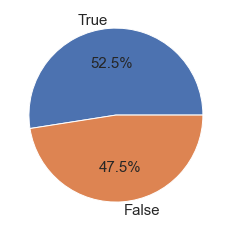

In [17]:
def boolean_pie_chart(ax, col, col_name=None, y_label=None):
    true = (col == 1).sum()
    false = (col == 0).sum()
    ax.pie([true, false], labels=["True", "False"], autopct='%1.1f%%')

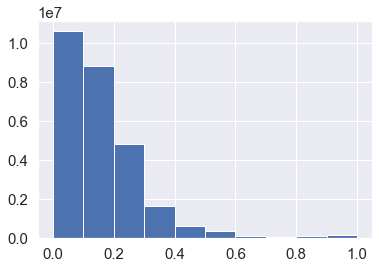

In [18]:
def hist_plot(ax, col, col_name=None, y_label=False):
    ax.hist(col)
    if col_name:
        ax.set_xlabel(col_name)
    if y_label:
        ax.set_ylabel("Number of occurences")

In [19]:
def plot_datasets(dfs, plt_func, col_name=""):
    fig, axs = plt.subplots(1, len(dfs), figsize=(10,3))
    for j, df in enumerate(dfs):
        if j == 0:
            y_label = 1
        else:
            y_label = 0
        plt_func[0](axs[j], df[0][plt_func[1]], col_name=col_name, y_label=y_label)
        axs[j].set_title(df[1])
    plt.tight_layout()
    plt.savefig(figure_folder + f"distribution_{col_name}.png")
    plt.show()

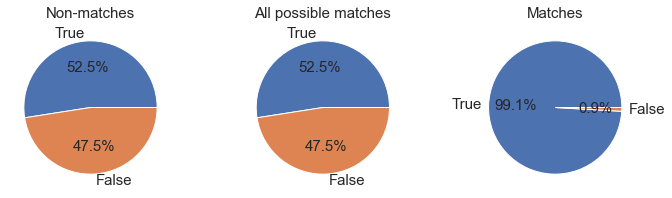

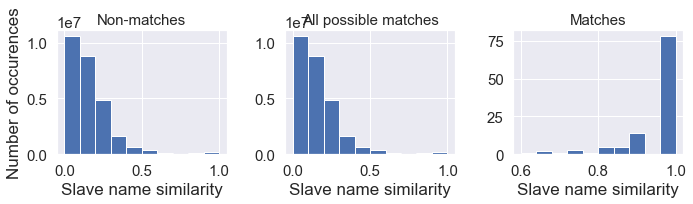

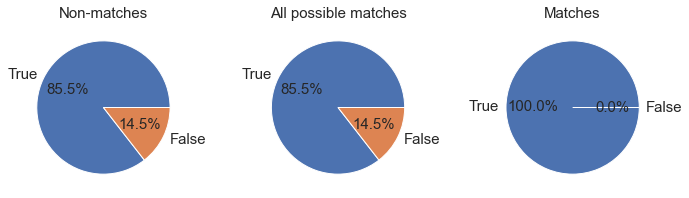

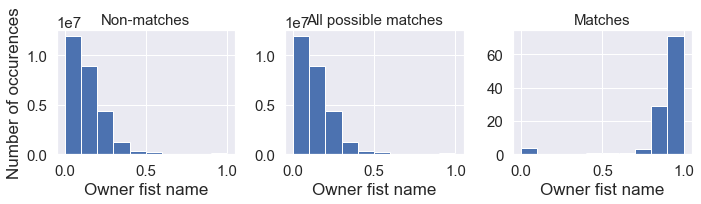

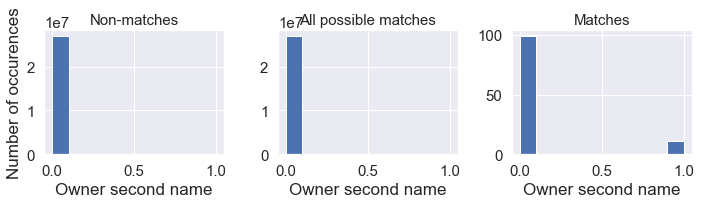

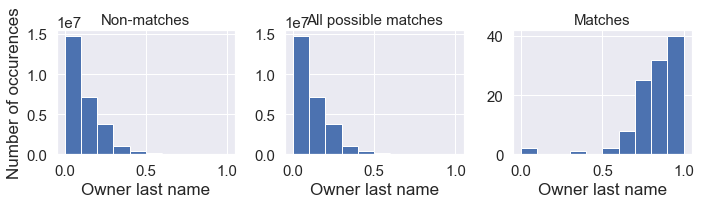

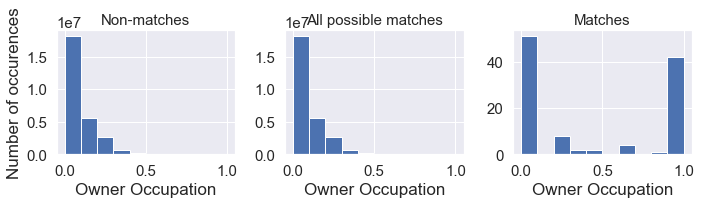

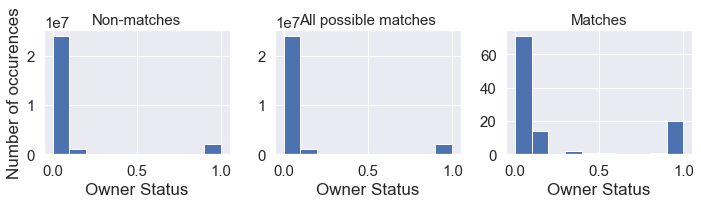

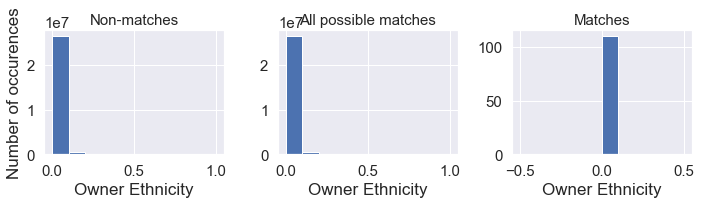

In [20]:
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (boolean_pie_chart, "SlaafGender"), col_name="Slave Gender")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "SlaafNaamNieuw"), col_name="Slave name similarity")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (boolean_pie_chart, "BezitterGender"), col_name="Owner Gender")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterVoornaam"), col_name="Owner fist name")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterTussen"), col_name="Owner second name")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterAchternaam"), col_name="Owner last name")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterBeroep"), col_name="Owner Occupation")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterStatus"), col_name="Owner Status")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterEtniciteit"), col_name="Owner Ethnicity")

In [25]:
mean_only_matches = only_matches.astype(float).mean()[3:-1]
no_only_matches = no_matches.astype(float).mean()[3:-1]

In [29]:
tv = []
pv = []
for col in only_matches.columns[3:-1]:
    res = ttest_ind(only_matches[col].astype(float), no_matches[col].astype(float), equal_var=False)
    tv.append(res.statistic)
    pv.append(res.pvalue)

In [31]:
index = ["Slave Gender Similarity", "Slave Name Similarity", "Owner Gender Similarity", "Owner First Name Similarity", "Owner Second Name Similarity", "Owner Last Name Similarity", "Owner Occupation Similarity", "Owner Status Similarity", "Owner Ethnicity Similarity"]
mean = pd.concat([mean_only_matches, no_only_matches, (mean_only_matches - no_only_matches).abs()], axis=1)
mean.index = index
mean.columns = ["Mean value of matches", "Mean value of non-Matches", "Difference of mean"]
mean["T-value"] = tv
mean["P-value"] = pv
print(mean.round(3).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean value of matches &  Mean value of non-Matches &  Difference of mean &   T-value &  P-value \\
\midrule
Slave Gender Similarity      &                  0.991 &                      0.525 &               0.466 &    51.278 &    0.000 \\
Slave Name Similarity        &                  0.951 &                      0.135 &               0.815 &    96.422 &    0.000 \\
Owner Gender Similarity      &                  1.000 &                      0.855 &               0.145 &  2149.851 &    0.000 \\
Owner First Name Similarity  &                  0.905 &                      0.121 &               0.784 &    40.378 &    0.000 \\
Owner Second Name Similarity &                  0.100 &                      0.008 &               0.092 &     3.187 &    0.002 \\
Owner Last Name Similarity   &                  0.840 &                      0.094 &               0.746 &    43.545 &    0.000 \\
Owner Occupation Similarity  &                  0.439 &            